In [ ]:
import numpy as np

def get_uv(xx, yy, p1, q1):
    p_x1, p_y1 = (p1[0], p1[1])
    q_x1, q_y1 = (q1[0], q1[1])
    qp_x1 = q_x1 - p_x1
    qp_y1 = q_y1 - p_y1
    qpnorm1 = (qp_x1 ** 2 + qp_y1 ** 2) ** 0.5

    u = ((xx - p_x1) * qp_x1 + (yy - p_y1) * qp_y1) / qpnorm1 ** 2
    v = ((xx - p_x1) * -qp_y1 + (yy - p_y1) * qp_x1) / qpnorm1
    return u,v

def get_xy(u, v, p2, q2):
    p_x2, p_y2 = (p2[0], p2[1])
    q_x2, q_y2 = (q2[0], q2[1])
    qp_x2 = q_x2 - p_x2
    qp_y2 = q_y2 - p_y2
    qpnorm2 = (qp_x2 ** 2 + qp_y2 ** 2) ** 0.5

    x = p_x2 + u * (q_x2 - p_x2) + (v * -qp_y2) / qpnorm2  # X'(x)
    y = p_y2 + u * (q_y2 - p_y2) + (v * qp_x2) / qpnorm2  # X'(y)
    return x,y

def get_weights(xx, yy, p1, q1):
    ### below same as get_uv function
    p_x1, p_y1 = (p1[0], p1[1])
    q_x1, q_y1 = (q1[0], q1[1])
    qp_x1 = q_x1 - p_x1
    qp_y1 = q_y1 - p_y1
    qpnorm1 = (qp_x1 ** 2 + qp_y1 ** 2) ** 0.5
    u = ((xx - p_x1) * qp_x1 + (yy - p_y1) * qp_y1) / qpnorm1 ** 2
    v = ((xx - p_x1) * -qp_y1 + (yy - p_y1) * qp_x1) / qpnorm1
    
    d1 = ((xx - q_x1) ** 2 + (yy - q_y1) ** 2) ** 0.5
    d2 = ((xx - p_x1) ** 2 + (yy - p_y1) ** 2) ** 0.5
    d = np.abs(v)
    d[u > 1] = d1[u > 1]
    d[u < 0] = d2[u < 0]
    W = (qpnorm1 ** 1 / (10 + d)) ** 1
    return W



def wrapOperator(style_img, input_img, style_lm, input_lm):
    src, dst, pq1, pq2 = (style_img, input_img, style_lm, input_lm)
    
    """style_img = np.float32(imread(style_img))
    input_img = np.float32(imread(input_img))
    style_mask = np.float32(imread(style_mask))
    input_mask = np.float32(imread(input_mask)) """

    # src = np.float32(src)
    # dst = np.float32(dst)
    h, w = src.shape
    
    ### add boundary points
    boundary_points = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0], [0, 0]])
    pq1 = np.vstack((pq1, boundary_points))
    pq2 = np.vstack((pq2, boundary_points))
    
    trans_coord = np.meshgrid(range(h), range(w), indexing='ij')
    yy, xx = trans_coord[0].astype(np.float64), trans_coord[1].astype(np.float64)

    xsum = np.zeros(xx.shape)
    ysum = np.zeros(yy.shape)
    wsum = np.zeros(xx.shape)
    ##### from face.con
    excluded_landmarks = [21, 26, 16, 30, 35, 47]
    delaunay_landmark_mapping = {41:36, 47:42, 59:48, 67:60}
    for i in range(len(pq1) - 1):
        ##### from face.con
        if i in excluded_landmarks:
            continue
        elif i in delaunay_landmark_mapping.keys():
            j = delaunay_landmark_mapping[i]
        else:
            j = i + 1
        
        u,v = get_uv(xx, yy, pq1[i], pq1[j])
        x,y = get_xy(u, v, pq2[i], pq2[j])
        weights = get_weights(xx, yy, pq1[i], pq1[j])

        wsum += weights
        xsum += weights * x
        ysum += weights * y

    x_m = xsum / wsum
    y_m = ysum / wsum
    vx = xx - x_m
    vy = yy - y_m

    vx[x_m < 1] = 0
    vx[x_m > w] = 0
    vy[y_m < 1] = 0
    vy[y_m > h] = 0

    vx = (vx + xx).astype(int)
    vy = (vy + yy).astype(int)
    vx[vx >= w] = w - 1
    vy[vy >= h] = h - 1

    return(vy, vx, yy, xx)


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

example_prefix = 'examples'
input_image_prefix, ref_image_prefix = ('6431431783_2b07a4f6fa_o','2910450431_56f1c774ed_z')
# input_image_prefix, ref_image_prefix = ('6431431783_2b07a4f6fa_o','2606298205_31cb5b5caf_z')
print(input_image_prefix, ref_image_prefix)

inputImg_bgr=(cv2.imread("../data/inputs/"+example_prefix+"/"+input_image_prefix+".png",cv2.IMREAD_COLOR))

refImg_bgr=(cv2.imread("../data/inputs/"+example_prefix+"/"+ref_image_prefix+".png",cv2.IMREAD_COLOR))

style_lm = np.array(pd.read_csv("../data/inputs/"+example_prefix+"/"+ref_image_prefix+".lm", header=None),dtype='float32')

input_lm = np.array(pd.read_csv("../data/inputs/"+example_prefix+"/"+input_image_prefix+".lm", header=None),dtype='float32')


6431431783_2b07a4f6fa_o 2910450431_56f1c774ed_z


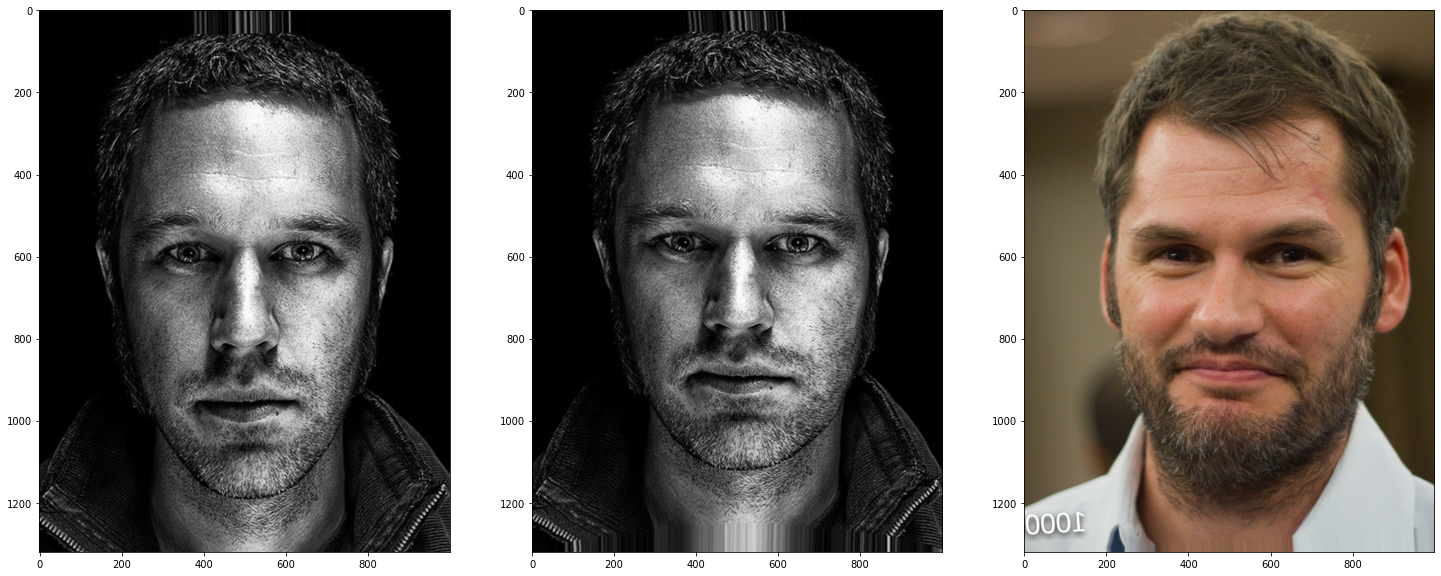

In [25]:
vy, vx, yy, xx =wrapOperator(style_img=refImg_bgr[:,:,0].copy(), input_img=inputImg_bgr[:,:,0].copy(), style_lm=style_lm, input_lm=input_lm)

refImg_bgr_warped = np.zeros_like(refImg_bgr)
refImg_bgr_warped[yy.astype(int), xx.astype(int)] = refImg_bgr[vy, vx]

fig = plt.figure(figsize=(25, 25))
fig.add_subplot(1, 3, 1)
plt.imshow(refImg_bgr[:,:,::-1])
fig.add_subplot(1, 3, 2)
plt.imshow(refImg_bgr_warped[:,:,::-1])
fig.add_subplot(1, 3, 3)
plt.imshow(inputImg_bgr[:,:,::-1])


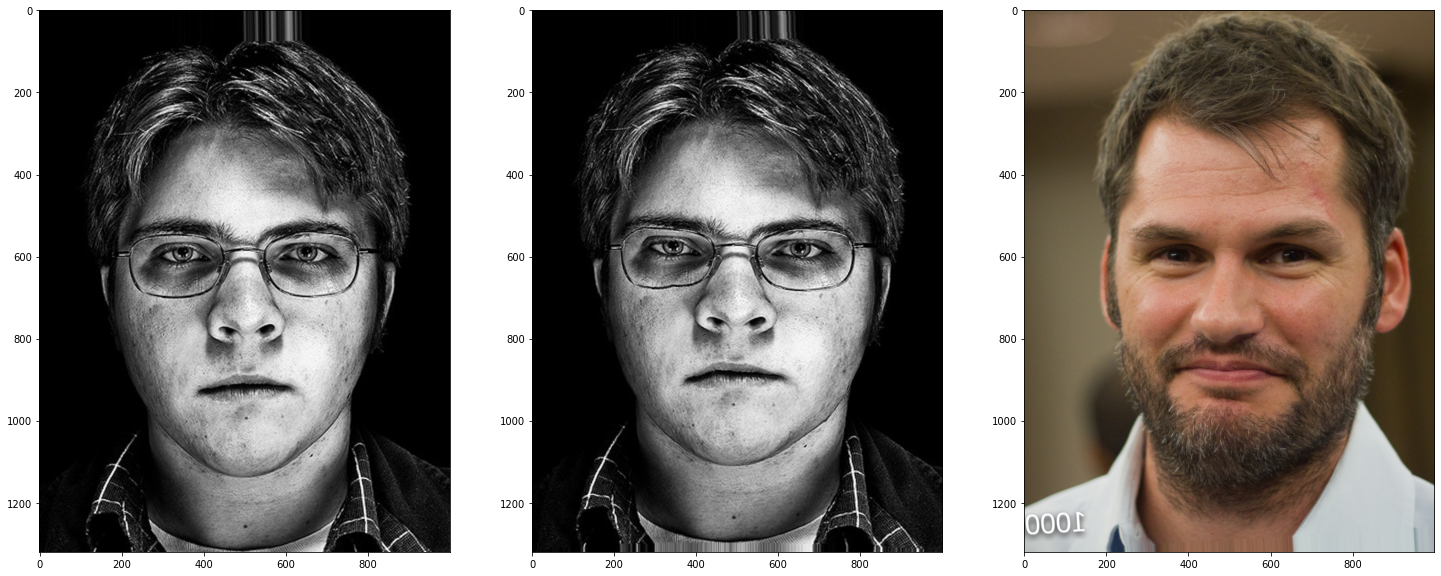

In [23]:
from WrapOperator import wrapOperator

vy, vx, yy, xx =wrapOperator(style_img=refImg_bgr[:,:,0].copy(), input_img=inputImg_bgr[:,:,0].copy(), style_lm=style_lm, input_lm=input_lm)

refImg_bgr_warped = np.zeros_like(refImg_bgr)
refImg_bgr_warped[yy.astype(int), xx.astype(int)] = refImg_bgr[vy, vx]

fig = plt.figure(figsize=(25, 25))
fig.add_subplot(1, 3, 1)
plt.imshow(refImg_bgr[:,:,::-1])
fig.add_subplot(1, 3, 2)
plt.imshow(refImg_bgr_warped[:,:,::-1])
fig.add_subplot(1, 3, 3)
plt.imshow(inputImg_bgr[:,:,::-1])
